<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Mohammad Jamshidi
### Student Number : 98100718
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torch import optim
from torchvision import utils
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [ ]:
###############################################################
##                Compose your transformations               ##
###############################################################
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]) # Write your code here

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [ ]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [ ]:
###############################################################
##           Load the datasets into train/valid              ##
##                       dataloaders                         ##
###############################################################
train_loader = DataLoader(train_data, batch_size=16, shuffle=True) # Write your code here
val_loader = DataLoader(valid_data, batch_size=16, shuffle=True) # Write your code here


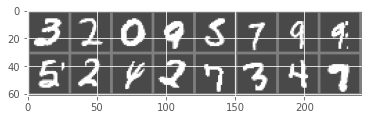

In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(utils.make_grid(images))

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [ ]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(16, 16, kernel_size=3, padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(16, 64, kernel_size=3, padding='same')
        self.conv5 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.conv6 = nn.Conv2d(64, 64, kernel_size=3, padding='same')
        self.pool3 = nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(64, 10)

    def forward(self, x):
        z = x
        z = F.relu(self.conv1(z))
        z = self.pool1(z)
        skip1 = z
        z = F.relu(self.conv2(z))
        z = F.relu(self.conv3(z))
        z = z + skip1
        z = self.pool2(z)
        z = F.relu(self.conv4(z))
        skip2 = z
        z = F.relu(self.conv5(z))
        z = F.relu(self.conv6(z))
        z = z + skip2
        z = self.pool3(z)
        z = self.flatten(z)
        z = self.linear(z)
        return z
      


In [ ]:
# model = ResidualClassifier()
# model.forward(train_loader)

# Train Model (30 Points)

In [ ]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################
model = ResidualClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

In [ ]:
######################################################################
##        Train your model (Complete the code below)                ##
######################################################################
total_step = len(train_loader)
num_epochs = 20
acc_per_epoch = np.zeros(num_epochs)
loss_val_per_epoch = np.zeros(num_epochs)
loss_train_per_epoch = np.zeros(num_epochs)
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:  
        optimizer.zero_grad()
        output = model(images)
        loss_train = criterion(output, labels)
        loss_train.backward()
        optimizer.step()
        running_loss += loss_train.item()
        # print(loss_train.item())
    loss_val = 0.0
    steps_val = 0
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            output = model(images)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # loss = criterion(output, labels)
            loss_val += criterion(output, labels)
            steps_val += 1
    acc_per_epoch[epoch] = correct / total
    loss_val_per_epoch[epoch] = loss_val / steps_val
    loss_train_per_epoch[epoch] = running_loss

In [ ]:
print(loss_train_per_epoch)

[5930.09658957 5809.54283416 5792.23568797]


[0.4401 0.9114 0.9326 0.9374 0.9609 0.9619 0.964  0.9743 0.9748 0.9762
 0.9761 0.9727 0.9783 0.974  0.9755 0.9798 0.9827 0.9837 0.9822 0.9838]
[1.61344302 0.28211156 0.21898118 0.19157022 0.13159095 0.12803653
 0.13178129 0.08549628 0.08416044 0.07887321 0.08349436 0.09075452
 0.07545456 0.08386388 0.08179495 0.06971963 0.06152017 0.05955459
 0.0600336  0.05736371]


Text(0.5, 1.0, 'Metrics Graph For Different Epochs')

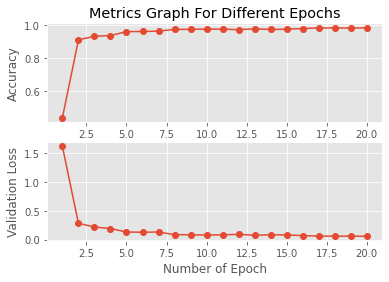

In [ ]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################
fig, (ax1, ax2) = plt.subplots(2, 1)
epochs = np.array([i+1 for i in range(num_epochs)])
print(acc_per_epoch)
print(loss_val_per_epoch)
ax1.plot(epochs, acc_per_epoch, '-o')
ax2.plot(epochs, loss_val_per_epoch, '-o')
ax2.set_xlabel('Number of Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Validation Loss')
ax1.set_title('Metrics Graph For Different Epochs')

# Test Model (20 Points)

In [ ]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))

acc = 0
loss_test = 0
y_true = []
y_pred = []

with torch.no_grad():
    loss_test = 0.0
    steps_test = 0
    total = 0
    correct = 0
    for images, labels in test_loader:
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        y_pred.extend(predicted)
        y_true.extend(labels.data)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # loss = criterion(output, labels)
        loss_test += criterion(output, labels)
        steps_test += 1
    acc = correct / total
    loss_test = loss_test / steps_test
  
print(f"""Info:
          accuracy: {acc}
          test loss: {loss_test}""")

cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)

10000
Info:
          accuracy: 0.9859
          test loss: 0.04442151263356209
[[ 974    0    3    0    1    0    1    1    0    0]
 [   0 1128    4    0    0    1    2    0    0    0]
 [   2    0 1030    0    0    0    0    0    0    0]
 [   0    0    5 1002    0    1    0    2    0    0]
 [   0    2    0    0  970    0    1    1    1    7]
 [   2    0    0    5    0  877    2    1    1    4]
 [   6    3    1    0    1    2  943    0    2    0]
 [   0    3   10    2    0    0    0 1010    1    2]
 [   8    0   15    4    2    2    0    0  937    6]
 [   2    1    1    4    6    1    0    4    2  988]]
